# MuscleHub AB Test

## Purpose:

## Goal: 

In [1]:
# import SQL module to access via python scripting
from codecademySQL import sql_query

## Dataset Description

SQLite database, with the following tables:

- `visits` contains information about potential gym customers who have visited MuscleHub
- `fitness_tests` contains information about potential customers in "Group A", who were given a fitness test
- `applications` contains information about any potential customers (both "Group A" and "Group B") who filled out an application.  Not everyone in `visits` will have filled out an application.
- `purchases` contains information about customers who purchased a membership to MuscleHub.


# 1 - Examine Tables 

In [4]:
# examine visits table
sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

,index,first_name,last_name,email,gender,visit_date
0,0,Karen,Manning,Karen.Manning@gmail.com,female,5-1-17
1,1,Annette,Boone,AB9982@gmail.com,female,5-1-17
2,2,Salvador,Merritt,SalvadorMerritt12@outlook.com,male,5-1-17
3,3,Martha,Maxwell,Martha.Maxwell@gmail.com,female,5-1-17
4,4,Andre,Mayer,AndreMayer90@gmail.com,male,5-1-17


In [5]:
# examine fitness_tests table
sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''')

,index,first_name,last_name,email,gender,fitness_test_date
0,0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [6]:
# examine applications table
sql_query('''
SELECT * 
FROM applications
LIMIT 5
''')

,index,first_name,last_name,email,gender,application_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [7]:
# examine purchases table
sql_query('''
SELECT *
FROM purchases
LIMIT 5
''')

,index,first_name,last_name,email,gender,purchase_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


# 2- Create Query to Assign A/B Test Relevant Data into DataFrame

In [8]:
# pull data after 7-1-17, the start of the AB test period, from visits, fitness_tests, applications, and purchases
# aggregated into 1 dataframe 

df = sql_query('''
SELECT visits.first_name,
       visits.last_name,
       visits.gender,
       visits.email,
       visits.visit_date,
       fitness_tests.fitness_test_date,
       applications.application_date,
       purchases.purchase_date
FROM visits 
LEFT JOIN fitness_tests 
        ON fitness_tests.first_name = visits.first_name
       AND fitness_tests.last_name = visits.last_name
       AND fitness_tests.email = visits.email
LEFT JOIN applications 
        ON applications.first_name = visits.first_name
       AND applications.last_name = visits.last_name
       AND applications.email = visits.email 
LEFT JOIN purchases 
        ON purchases.first_name = visits.first_name
       AND purchases.last_name = visits.last_name
       AND purchases.email = visits.email 
WHERE visits.visit_date >= '7-1-17'

''')

print (df.head())

  first_name last_name  gender                   email visit_date  \
0        Kim    Walter  female   KimWalter58@gmail.com     7-1-17   
1        Tom   Webster    male        TW3857@gmail.com     7-1-17   
2     Edward     Bowen    male  Edward.Bowen@gmail.com     7-1-17   
3     Marcus     Bauer    male  Marcus.Bauer@gmail.com     7-1-17   
4    Roberta      Best  female      RB6305@hotmail.com     7-1-17   

  fitness_test_date application_date purchase_date  
0        2017-07-03             None          None  
1        2017-07-02             None          None  
2              None       2017-07-04    2017-07-04  
3        2017-07-01       2017-07-03    2017-07-05  
4        2017-07-02             None          None  


# 3- Investigate the A and B groups

In [9]:
import pandas as pd 
from matplotlib import pyplot as plt 

## Partition Visitors - Add Column: A/B Test Group 

Values to be returned: 
##### `A` if `fitness_test_date` = Not None
##### `B` if `fitness_test_date` = None

In [10]:
# add ab_test_group column to df by defining lambda function with above logic 
df['ab_test_group'] = df.fitness_test_date.apply(lambda x: 
                                                 'A' if pd.notnull(x) else 'B')

#### Sanity Check: Equal Visitor Split 

In [11]:
#count how many users are in each ab_test_group
ab_counts = df.groupby('ab_test_group').first_name.count().reset_index()
ab_counts

,ab_test_group,first_name
0,A,2504
1,B,2500


#### Sanity Check: Visualize

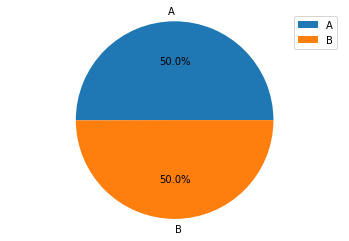

<Figure size 432x288 with 0 Axes>

In [12]:
# create pie chart to plot A/B group split 
plt.pie(ab_counts.first_name.values, labels=['A', 'B'], autopct='%0.1f%%')
plt.axis('equal')
plt.legend()
plt.show()
plt.savefig('ab_test_pie_chart.png')

# 4- Who Picks Up an Application?

### Steps in Application Process

1. Take a fitness test with a personal trainer (only Group A)
2. Fill out an application for the gym
3. Send in their payment for their first month's membership

#### How many people make it to step 2?

In [13]:
# examine how many people make it to step 2 of the process, filling out an application
df['is_application'] = df.application_date.apply(lambda x:
                                                 'Application' if pd.notnull(x) else 'No Application')

#### How many people do or don't pick up an application? 

In [14]:
# count how many people from Group A and Group B either do or don't pick up an application 
app_counts = df.groupby(['ab_test_group', 'is_application']).first_name.count().reset_index()
app_counts

,ab_test_group,is_application,first_name
0,A,Application,250
1,A,No Application,2254
2,B,Application,325
3,B,No Application,2175


#### Count percent of people in each group who complete an application.

In [15]:
# pivot app_counts so ab_test_group = index and is_application = columns
app_pivot = app_counts.pivot(columns='is_application', index='ab_test_group', values='first_name').reset_index()
app_pivot

is_application,ab_test_group,Application,No Application
0,A,250,2254
1,B,325,2175


In [16]:
# define new column, Total 
app_pivot['Total'] = app_pivot['Application'] + app_pivot['No Application']

In [17]:
# define new column 'Percent with Application'
app_pivot['Percent with Application'] = app_pivot['Application'] / app_pivot['Total']
app_pivot

is_application,ab_test_group,Application,No Application,Total,Percent with Application
0,A,250,2254,2504,0.09984
1,B,325,2175,2500,0.13000


#### Checkpoint

* More people from Group B turned in an application. Need to determine whether the difference is statistically significant or not with Chi-Squared test from SciPy. 

In [18]:
# import scipy to do a chi-squared test

from scipy.stats import chi2_contingency

# create contingency table with values from app_pivot
contingency = [[250, 2254],
               [325, 2175]]

# display chi2 results 
chi2_contingency(contingency)

(10.893961295282612,
 0.0009647827600722304,
 1,
 array([[ 287.72981615, 2216.27018385],
        [ 287.27018385, 2212.72981615]]))

#### Chi-squared Interpretation:
* There is a statistically significant difference b/w the groups A and B because the p-value is 0.000964, which is significantly lower than 0.05, so we reject the null hypothesis that there is no significant difference between the two groups 

# 5- Who purchases a membership?

In [19]:
# add is_member column to df, which is Member if purchase_date is not none and Not Member otherwise 
df['is_member'] = df.purchase_date.apply(lambda x: 'Member' if pd.notnull(x) else 'Not Member')

In [20]:
# create just apps dataframe, which contains only people who picked up an application 
just_apps = df[df.is_application == 'Application']
just_apps

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date,ab_test_group,is_application,is_member
2,Edward,Bowen,male,Edward.Bowen@gmail.com,7-1-17,None,2017-07-04,2017-07-04,B,Application,Member
3,Marcus,Bauer,male,Marcus.Bauer@gmail.com,7-1-17,2017-07-01,2017-07-03,2017-07-05,A,Application,Member
9,Salvador,Cardenas,male,SCardenas1980@gmail.com,7-1-17,2017-07-07,2017-07-06,None,A,Application,Not Member
11,Valerie,Munoz,female,VMunoz1998@gmail.com,7-1-17,2017-07-03,2017-07-05,2017-07-06,A,Application,Member
35,Michael,Burks,male,MB9820@gmail.com,7-1-17,None,2017-07-07,2017-07-13,B,Application,Member
36,Clyde,Patrick,male,Clyde.Patrick@gmail.com,7-1-17,None,2017-07-07,None,B,Application,Not Member
69,Sonia,Harrell,female,SoniaHarrell53@gmail.com,7-10-17,None,2017-07-12,2017-07-14,B,Application,Member
95,Marlene,Barron,female,MBarron1979@yahoo.com,7-10-17,None,2017-07-11,2017-07-15,B,Application,Member
106,Nelson,Dejesus,male,ND1356@gmail.com,7-10-17,None,2017-07-10,None,B,Application,Not Member
122,Lisa,Kramer,female,Lisa.Kramer@gmail.com,7-10-17,None,2017-07-14,2017-07-18,B,Application,Member


In [21]:
# use groupby to find out how many people in just_apps are and aren't members from each group 
just_apps_counts = just_apps.groupby(['ab_test_group', 'is_member']).first_name.count().reset_index()

# pivot just_apps_counts for later analysis 
just_apps_pivot = just_apps_counts.pivot(columns='is_member', index='ab_test_group', values='first_name').reset_index()

# add 'Total' column to just_apps_pivot 
just_apps_pivot['Total'] = just_apps_pivot['Member'] + just_apps_pivot['Not Member']

#add 'Percent Purchase' column to just_apps_pivot
just_apps_pivot['Percent Purchase'] = just_apps_pivot['Member'] / just_apps_pivot['Total']

# display just_apps_pivot
just_apps_pivot



is_member,ab_test_group,Member,Not Member,Total,Percent Purchase
0,A,200,50,250,0.800000
1,B,250,75,325,0.769231


#### Checkpoint: Determine if Percent Purchase Difference is Statistically Significant 

In [22]:
# import chi2_contingency from scipy 
from scipy.stats import chi2_contingency

# construct contingency table from just_apps_pivot
contingency = [[200, 50],
              [250, 75]]

# display chi2 test results
chi2_contingency(contingency)



(0.615869230769231,
 0.43258646051083327,
 1,
 array([[195.65217391,  54.34782609],
        [254.34782609,  70.65217391]]))

#### Chi-squared Interpretation:

* There is not a statistically significant difference b/w the groups A and B because the p-value is 0.43258646051083327, which is significantly higher than 0.05, so we fail to reject the null hypothesis that there is no significant difference between the two groups. 

### How many people are and aren't members from each group? 

In [23]:
# create final_member_count dataframe 
final_member_count = df.groupby(['ab_test_group', 'is_member']).first_name.count().reset_index()

# pivot final_member_count
final_member_pivot = final_member_count.pivot(columns='is_member', index='ab_test_group', values='first_name')

# add 'Total' column
final_member_pivot['Total'] = final_member_pivot['Member'] + final_member_pivot['Not Member']

# add 'Is Purchase' column
final_member_pivot['Is Purchase'] = final_member_pivot['Member'] / final_member_pivot['Total']

# display final_member_pivot
final_member_pivot

is_member,Member,Not Member,Total,Is Purchase
ab_test_group,,,,
A,200,2304,2504,0.079872
B,250,2250,2500,0.100000


Previously, when only people who had **already picked up an application** was considered, there was no significant difference in membership between Group A and Group B.

Now, when all people who **visit MuscleHub** are considered, there might be a significant different in memberships between Group A and Group B. I'll now perform a significance test to check it out. 

In [24]:
# create contingency table based on final_member_pivot
contingency = [[200, 2304],
              [250, 2250]]

# display chi2 results
chi2_contingency(contingency)

(5.949182292591156,
 0.014724114645783203,
 1,
 array([[ 225.17985612, 2278.82014388],
        [ 224.82014388, 2275.17985612]]))

# 6- Summarize Acquisition funel With a Chart

Now that the analysis has been done, I'll make a bar chart that shows the difference between Group A (people who were given the fitness test) and Group B (people who were not given the fitness test) at each state of the process:
- Percent of visitors who apply
- Percent of applicants who purchase a membership
- Percent of visitors who purchase a membership

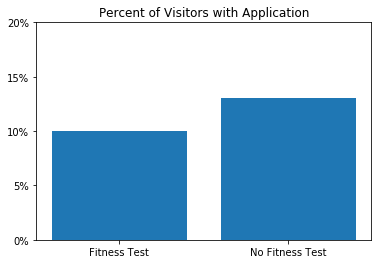

In [25]:
# create axis object 
ax = plt.subplot()

#create 'Percent with Application' bar chart 
plt.bar(range(len(app_pivot)), app_pivot['Percent with Application'].values)

# specify x-axis tick marks 
ax.set_xticks(range(len(app_pivot)))

# specify x-axis tick labels 
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])

# specify y-axis tick marks
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.2])

# specify y-axis tick labels 
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])

# give chart a title
plt.title('Percent of Visitors with Application')

# save chart as png file 
plt.savefig('percent_visitors_apply.png')

Text(0.5, 1.0, 'Percent of Applicants who Purchased Membership')

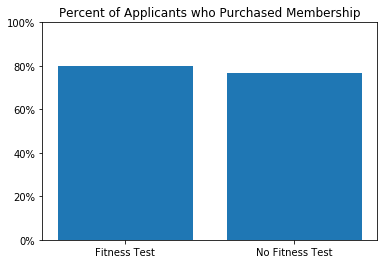

In [26]:
# create axis object for second chart 
ax = plt.subplot()

#create 'Percent Purchase' bar chart 
plt.bar(range(len(just_apps_pivot)), just_apps_pivot['Percent Purchase'])

# specify x-axis tick marks 
ax.set_xticks(range(len(just_apps_pivot)))

# specify x-axis tick labels 
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])

# specify y-axis tick marks
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# specify y-axis tick labels 
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# give chart a title
plt.title('Percent of Applicants who Purchased Membership')

# save chart as png file 
plt.savefig('percent_applicants_purchase.png')

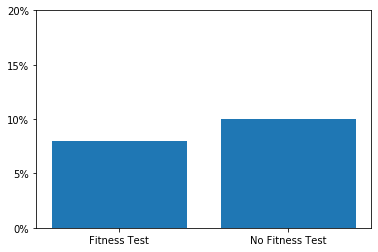

<Figure size 432x288 with 0 Axes>

In [27]:
# create axis object 
ax = plt.subplot()

#create 'Is Purchase' bar chart 
plt.bar(range(len(final_member_pivot)),
       final_member_pivot['Is Purchase'].values)

# specify x-axis tick marks 
ax.set_xticks(range(len(app_pivot)))

# specify x-axis tick labels 
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])

# specify y-axis tick marks
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])

# specify y-axis tick labels 
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])

# give chart a title
plt.title('Percent of Visitors who Purchased a Membership')

# save chart as png file 
plt.savefig('percent_visitors_purchase.png')